In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
plt.rcParams['figure.figsize'] = [7,7]
plt.rcParams['font.size'] =10
plt.rcParams['font.weight']= 'bold'
from sklearn.utils.fixes import parse_version
import xgboost as xgb

In [2]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.shape

(1338, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


#### DATA CLEANING & EDA

In [6]:
df.isnull().any()

age         False
sex         False
bmi         False
children    False
smoker      False
region      False
charges     False
dtype: bool

In [7]:
df.duplicated().any()

True

In [8]:
df.corr()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


<AxesSubplot:>

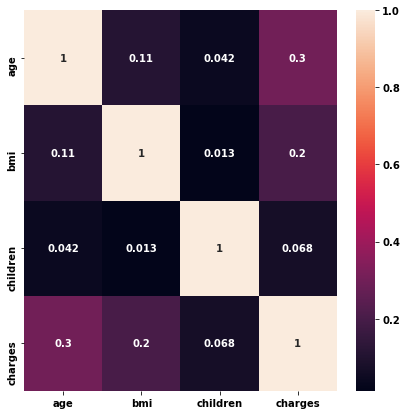

In [9]:
sns.heatmap(df.corr(), annot = True)

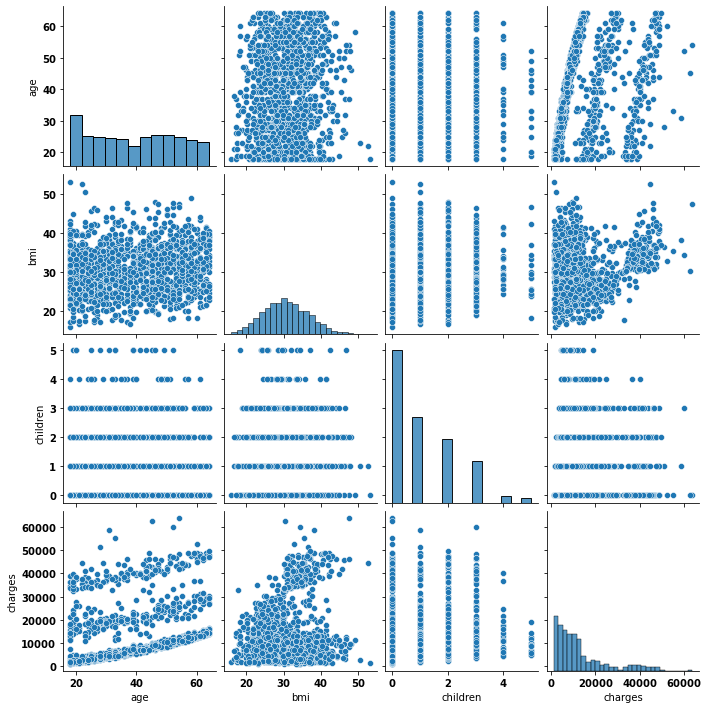

In [10]:
sns.pairplot(df)

<AxesSubplot:xlabel='age', ylabel='Count'>

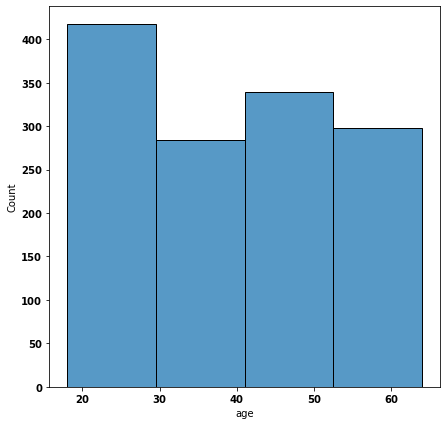

In [11]:
sns.histplot(x= 'age',data=df, bins = 4)

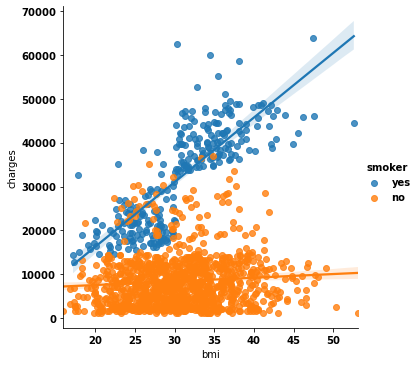

In [12]:
sns.lmplot(x= 'bmi', y='charges', hue='smoker',data=df)

<AxesSubplot:xlabel='count', ylabel='smoker'>

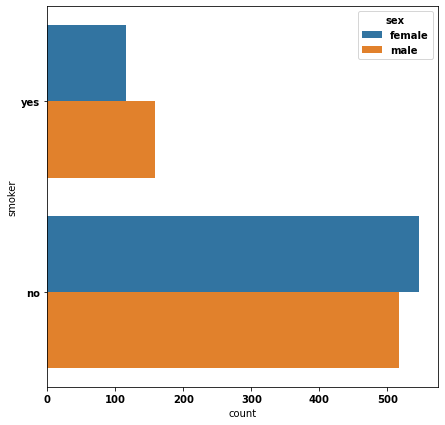

In [13]:
sns.countplot(y= 'smoker', hue = 'sex', data= df)

<AxesSubplot:xlabel='region', ylabel='charges'>

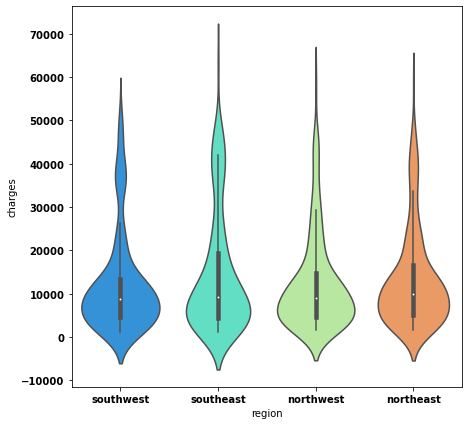

In [14]:
sns.violinplot(x = 'region', y= 'charges', data= df, palette = 'rainbow')

<AxesSubplot:xlabel='children', ylabel='charges'>

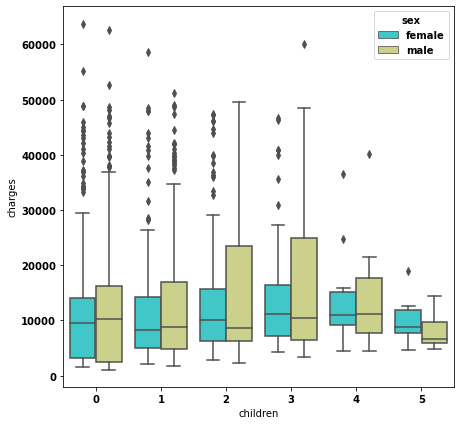

In [15]:
sns.boxplot(x='children', y='charges',hue='sex',data=df,palette='rainbow')

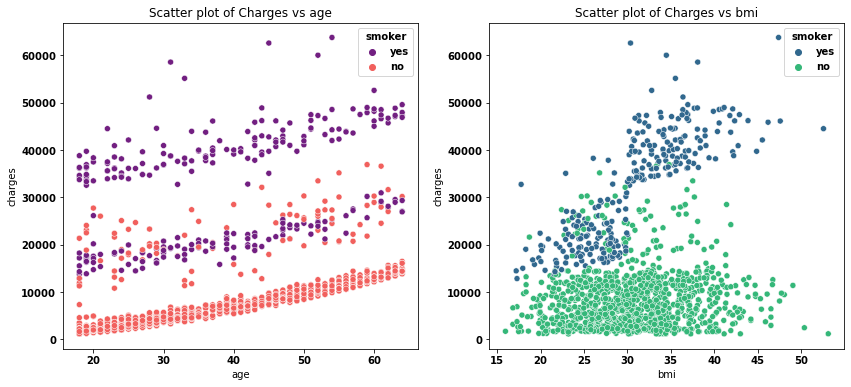

In [16]:
f = plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.scatterplot(x='age',y='charges',data=df,palette='magma',hue='smoker',ax=ax)
ax.set_title('Scatter plot of Charges vs age')

ax = f.add_subplot(122)
sns.scatterplot(x='bmi',y='charges',data=df,palette='viridis',hue='smoker')
ax.set_title('Scatter plot of Charges vs bmi')
plt.savefig('sc.png');

#### FEATURE ENGINEERING

In [17]:
#Converting Categorical Variables into numerical encoders
cat_cols = ['sex','smoker','region']

In [18]:
one_hot = pd.get_dummies(df[cat_cols], drop_first = True)

df = pd.concat([df, one_hot], axis=1)
df.head()

,age,sex,bmi,children,smoker,region,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,female,27.900,0,yes,southwest,16884.92400,0,1,0,0,1
1,18,male,33.770,1,no,southeast,1725.55230,1,0,0,1,0
2,28,male,33.000,3,no,southeast,4449.46200,1,0,0,1,0
3,33,male,22.705,0,no,northwest,21984.47061,1,0,1,0,0
4,32,male,28.880,0,no,northwest,3866.85520,1,0,1,0,0


In [19]:
df = df.drop(columns= ['sex','smoker','region'])

In [20]:
df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


In [21]:
##Scaling Independent features & Normalizing Dependent Variable
from sklearn.preprocessing import StandardScaler
#Standard scaling the independent features

scaler = StandardScaler()
scaler.fit(df.drop(columns=['charges']))
scaled_features = scaler.transform(df.drop(columns=['charges']))

In [22]:
df_standard = pd.DataFrame(scaled_features, columns = df.columns[:-1])
df_standard = df_standard.drop(columns = ['charges'])
df_standard[:5]

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast
0,-1.438764,-0.453320,-0.908614,1.970587,-0.566418,-0.611324,1.765481
1,-1.509965,0.509621,-0.078767,-0.507463,-0.566418,1.635795,-0.566418
2,-0.797954,0.383307,1.580926,-0.507463,-0.566418,1.635795,-0.566418
3,-0.441948,-1.305531,-0.908614,-0.507463,1.765481,-0.611324,-0.566418
4,-0.513149,-0.292556,-0.908614,-0.507463,1.765481,-0.611324,-0.566418


In [23]:
df_standard.corr()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast
age,1.000000,0.109272,0.042469,-0.025019,-0.000407,-0.011642,0.010016
bmi,0.109272,1.000000,0.012759,0.003750,-0.135996,0.270025,-0.006205
children,0.042469,0.012759,1.000000,0.007673,0.024806,-0.023066,0.021914
sex_male,-0.025019,0.003750,0.007673,1.000000,-0.036945,0.068498,-0.036945
smoker_yes,-0.000407,-0.135996,0.024806,-0.036945,1.000000,-0.346265,-0.320829
region_northwest,-0.011642,0.270025,-0.023066,0.068498,-0.346265,1.000000,-0.346265
region_southeast,0.010016,-0.006205,0.021914,-0.036945,-0.320829,-0.346265,1.000000


<AxesSubplot:>

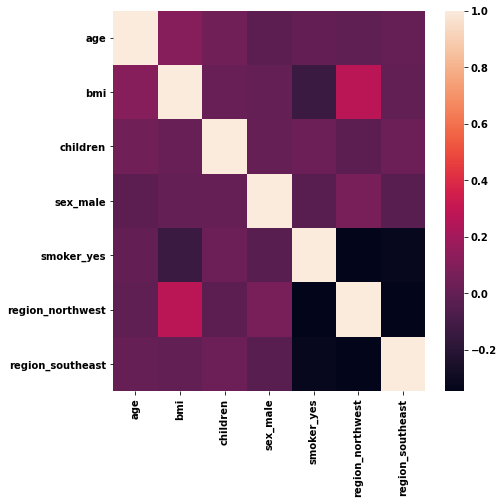

In [24]:
sns.heatmap(df_standard.corr())

In [25]:
df_standard['charges'] = df.charges

In [26]:
X = df_standard.drop(columns = ['charges'])
y = df_standard.charges

#### FEATURE SELECTION

In [27]:
from sklearn.feature_selection import mutual_info_regression

In [28]:
discrete_features = X.dtypes == int

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [30]:
def make_mi_scores(X_train, y_train, discrete_features):
    mi_scores = mutual_info_regression(X_train, y_train, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X_train, y_train, discrete_features)

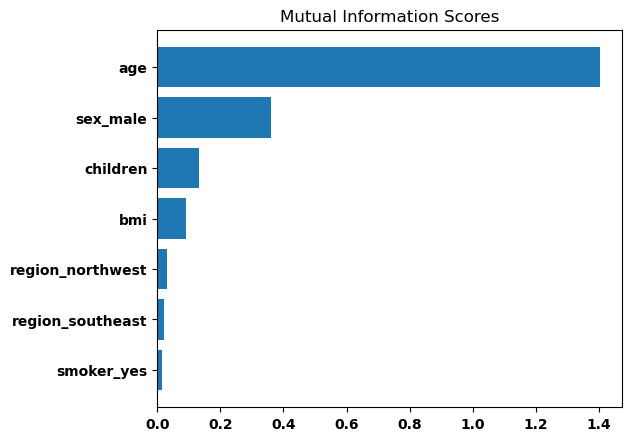

In [31]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(6, 5))
plot_mi_scores(mi_scores)  

In [32]:
from sklearn.feature_selection import SelectKBest

selector = SelectKBest(mutual_info_regression, k=4)
selector.fit(X_train, y_train)
X.columns[selector.get_support()]

Index(['age', 'bmi', 'children', 'sex_male'], dtype='object')

In [33]:
new_features = ['age', 'bmi', 'children', 'sex_male']

X = X[new_features]

#### MODEL BUILDING

In [34]:
regressor = xgb.XGBRegressor()

In [35]:
regressor.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [36]:
#Hyperparameter tuning

params = {
    "n_estimators" : [100, 500, 700, 900],
    "base_score"     : [0.25, 0.5, 0.75, 1],
    "learning_rate"   : [0.05, 0.1, 0.15, 0.2],
    "booster"        : ['gbtree','gblinear'],
    "max_depth"         : [2,3, 5, 10],
    "min_child_weight"  : [1,3,5,7],
}


In [37]:
from sklearn.model_selection import RandomizedSearchCV

In [38]:
regressor = xgb.XGBRegressor()

random_search = RandomizedSearchCV(estimator= regressor, param_distributions = params , cv=5, n_iter = 50, 
                                   scoring ='neg_mean_absolute_error', verbose = 5, return_train_score = True, random_state=42)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[02:15:25] WARNING: ..\src\learner.cc:541: 
Parameters: { max_depth, min_child_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 1/5] END base_score=0.75, booster=gblinear, learning_rate=0.2, max_depth=2, min_child_weight=3, n_estimators=100;, score=(train=-4216.775, test=-4172.620) total time=   0.0s
[02:15:25] WARNING: ..\src\learner.cc:541: 
Parameters: { max_depth, min_child_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 2/5] END base_score=0.75, booster=gblinear, learning_rate=0.2,

[CV 3/5] END base_score=1, booster=gblinear, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=700;, score=(train=-4169.580, test=-4454.703) total time=   0.0s
[02:15:34] WARNING: ..\src\learner.cc:541: 
Parameters: { max_depth, min_child_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 4/5] END base_score=1, booster=gblinear, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=700;, score=(train=-4043.112, test=-4460.391) total time=   0.0s
[02:15:34] WARNING: ..\src\learner.cc:541: 
Parameters: { max_depth, min_child_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

[CV 1/5] END base_score=0.75, booster=gblinear, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=700;, score=(train=-4216.777, test=-4172.622) total time=   0.0s
[02:15:40] WARNING: ..\src\learner.cc:541: 
Parameters: { max_depth, min_child_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 2/5] END base_score=0.75, booster=gblinear, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=700;, score=(train=-4213.676, test=-4122.081) total time=   0.0s
[02:15:40] WARNING: ..\src\learner.cc:541: 
Parameters: { max_depth, min_child_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification

[CV 1/5] END base_score=0.25, booster=gblinear, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=500;, score=(train=-4216.777, test=-4172.622) total time=   0.0s
[02:15:53] WARNING: ..\src\learner.cc:541: 
Parameters: { max_depth, min_child_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 2/5] END base_score=0.25, booster=gblinear, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=500;, score=(train=-4213.676, test=-4122.081) total time=   0.0s
[02:15:53] WARNING: ..\src\learner.cc:541: 
Parameters: { max_depth, min_child_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification

[CV 1/5] END base_score=0.75, booster=gblinear, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=700;, score=(train=-4216.777, test=-4172.623) total time=   0.0s
[02:15:57] WARNING: ..\src\learner.cc:541: 
Parameters: { max_depth, min_child_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 2/5] END base_score=0.75, booster=gblinear, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=700;, score=(train=-4213.678, test=-4122.082) total time=   0.0s
[02:15:57] WARNING: ..\src\learner.cc:541: 
Parameters: { max_depth, min_child_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verificati

[CV 3/5] END base_score=0.5, booster=gblinear, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=700;, score=(train=-4169.580, test=-4454.704) total time=   0.0s
[02:15:59] WARNING: ..\src\learner.cc:541: 
Parameters: { max_depth, min_child_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 4/5] END base_score=0.5, booster=gblinear, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=700;, score=(train=-4043.115, test=-4460.393) total time=   0.0s
[02:15:59] WARNING: ..\src\learner.cc:541: 
Parameters: { max_depth, min_child_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. 

[02:16:05] WARNING: ..\src\learner.cc:541: 
Parameters: { max_depth, min_child_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 5/5] END base_score=1, booster=gblinear, learning_rate=0.05, max_depth=10, min_child_weight=5, n_estimators=100;, score=(train=-4230.833, test=-3882.469) total time=   0.0s
[02:16:05] WARNING: ..\src\learner.cc:541: 
Parameters: { max_depth, min_child_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 1/5] END base_score=0.5, booster=gblinear, learning_rate=0.15, max_depth=5, min_child_weight=1, n_estimators=700;, score=(tra

[CV 5/5] END base_score=0.25, booster=gblinear, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=700;, score=(train=-4248.795, test=-3890.485) total time=   0.0s
[CV 1/5] END base_score=1, booster=gbtree, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=700;, score=(train=-1773.838, test=-2614.784) total time=   0.4s
[CV 2/5] END base_score=1, booster=gbtree, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=700;, score=(train=-1856.607, test=-2612.679) total time=   0.4s
[CV 3/5] END base_score=1, booster=gbtree, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=700;, score=(train=-1721.023, test=-2986.397) total time=   0.4s
[CV 4/5] END base_score=1, booster=gbtree, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=700;, score=(train=-1623.288, test=-3191.250) total time=   0.4s
[CV 5/5] END base_score=1, booster=gbtree, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=700;, score=(trai

[CV 1/5] END base_score=0.75, booster=gblinear, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=700;, score=(train=-4216.777, test=-4172.622) total time=   0.0s
[02:16:31] WARNING: ..\src\learner.cc:541: 
Parameters: { max_depth, min_child_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 2/5] END base_score=0.75, booster=gblinear, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=700;, score=(train=-4213.676, test=-4122.081) total time=   0.0s
[02:16:31] WARNING: ..\src\learner.cc:541: 
Parameters: { max_depth, min_child_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification

[CV 5/5] END base_score=1, booster=gbtree, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=900;, score=(train=-1768.137, test=-2853.003) total time=   0.5s
[CV 1/5] END base_score=0.25, booster=gbtree, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500;, score=(train=-2042.747, test=-2439.991) total time=   0.3s
[CV 2/5] END base_score=0.25, booster=gbtree, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500;, score=(train=-2149.008, test=-2333.192) total time=   0.3s
[CV 3/5] END base_score=0.25, booster=gbtree, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500;, score=(train=-1891.998, test=-2913.679) total time=   0.3s
[CV 4/5] END base_score=0.25, booster=gbtree, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500;, score=(train=-1918.753, test=-2958.889) total time=   0.3s
[CV 5/5] END base_score=0.25, booster=gbtree, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=500;, 

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                          tree_method=None,
                                          validate_parameters=None,
                                          verbosity=None),
   

In [39]:
random_search.best_estimator_

XGBRegressor(base_score=1, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [40]:
model = xgb.XGBRegressor(base_score=1, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=5, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


In [41]:
from sklearn.model_selection import cross_val_score

In [42]:
score = cross_val_score(model, X_train, y_train, cv =5)

In [43]:
score

array([0.86516877, 0.91544781, 0.83980661, 0.78707884, 0.85498304])

In [45]:
score.mean()

0.8524970124555076

In [46]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

y_pred[:10]

array([10069.707 ,  6213.1143, 26764.586 , 10069.707 , 35676.06  ,
        5744.135 ,  2054.9521, 14923.409 ,  4378.0986, 11373.94  ],
      dtype=float32)